In [192]:
import sklearn
import numpy as np
import pandas as pd
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

Read the data

In [193]:
df = pd.read_excel('default of credit card clients.xls', index_col = 0, header = 1)

In [194]:
df.rename(columns={'default payment next month':'default'}, inplace=True)

Encoding categorical data

In [195]:
df['EDUCATION'] = df['EDUCATION'].astype('category')
df['SEX'] = df['SEX'].astype('category')
df['MARRIAGE'] = df['MARRIAGE'].astype('category')

df=pd.concat([pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'), 
                  pd.get_dummies(df['SEX'], prefix='SEX'), 
                  pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                  df],axis=1)
df.drop(['EDUCATION'],axis=1, inplace=True)
df.drop(['SEX'],axis=1, inplace=True)
df.drop(['MARRIAGE'],axis=1, inplace=True)
df.head()

,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,SEX_1,SEX_2,MARRIAGE_0,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,689,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,0,0,1,0,0,0,0,0,1,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,0,0,1,0,0,0,0,0,1,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,0,0,1,0,0,0,0,1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Computed feature

In [196]:
pay_vars = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5', 'PAY_6']
df.insert(0, "DELAYED", (df[pay_vars] > 0).sum(axis=1))

In [197]:
data = np.array(df)
X_train, X_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size = 0.33, random_state = 42)

In [198]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest

preprocessing = Pipeline([('scaler', StandardScaler()),
                          ('imputer', SimpleImputer())
                          ])

feature_selection = Pipeline([('SelectKBest', SelectKBest())])

In [199]:
from sklearn.linear_model import LogisticRegression

classifier = RandomForestClassifier()

In [260]:
param_grid = {
                'preprocessing__imputer__strategy' : ['mean'],
                'feature_selection__SelectKBest__k' : [3], 
                'classifier__n_estimators' : [22],
                'classifier__class_weight' : ['balanced']
                }

In [261]:
n_folds = 5

from sklearn.model_selection import KFold

def create_folds(X,y,n_folds):
    folds = []
    cv_object = KFold(n_splits = n_folds)
    for (train_indices, val_indices) in cv_object.split(X_train, y_train):
        folds.append((train_indices,val_indices))
    return folds

In [262]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit='f1', scoring=['accuracy', 'f1', 'roc_auc'] )
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=[(array([ 4020,  4021,  4022, ..., 20097, 20098, 20099]),
                  array([   0,    1,    2, ..., 4017, 4018, 4019])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([4020, 4021, 4022, ..., 8037, 8038, 8039])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([ 8040,  8041,  8042, ..., 12057, 12058, 12059])),
                 (array([    0,     1,     2, ..., 20097, 20098, 20099]),
                  array([12060, 12061, 12062, ..., 16077, 16078, 16079...
                                        Pipeline(steps=[('SelectKBest',
                                                         SelectKBest())])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'classifier__class_weight': ['balanced'],
                         'classifier__n_estimators': [22

In [263]:
results = cv.cv_results_
mean_train_score = results['mean_train_f1'][cv.best_index_]
std_train_score = results['std_train_f1'][cv.best_index_]
mean_cv_score = results['mean_test_f1'][cv.best_index_]
std_cv_score = results['std_test_f1'][cv.best_index_]

mean_cv_acc = results['mean_test_accuracy'][cv.best_index_]
std_cv_acc = results['std_test_accuracy'][cv.best_index_]

mean_cv_auc = results['mean_test_roc_auc'][cv.best_index_]
std_cv_auc = results['std_test_roc_auc'][cv.best_index_]


print('Training f1 {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation f1: {} +/- {}'.format(mean_cv_score, std_cv_score))
print('Cross-validation acc: {} +/- {}'.format(mean_cv_acc, std_cv_acc))
print('Cross-validation auc: {} +/- {}'.format(mean_cv_auc, std_cv_auc))

print('Best estimator:')
print(cv.best_estimator_)

Training f1 0.53546901146676 +/- 0.004930816356043681
Cross-validation f1: 0.5266609194967955 +/- 0.00950661560039393
Cross-validation acc: 0.7651243781094527 +/- 0.007973248010971403
Cross-validation auc: 0.7429594632788736 +/- 0.007657196196595553
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('imputer', SimpleImputer())])),
                ('feature_selection',
                 Pipeline(steps=[('SelectKBest', SelectKBest(k=3))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=22))])


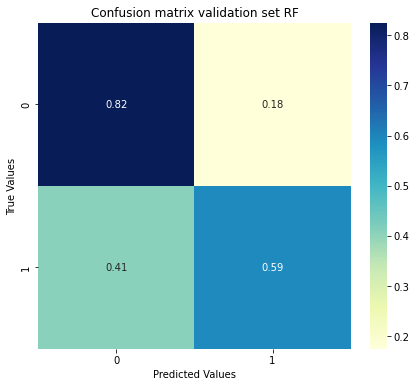

In [264]:
for _, val_indices in folds:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    X = X_train[val_indices]
    y = y_train[val_indices]
    y_pred = cv.best_estimator_.predict(X)
    labels = y
    cm = confusion_matrix(y, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.title("Confusion matrix validation set RF")
    plt.show(block=False)
    break


Prediction only dominant class: ROC AUC=0.500
Model: ROC AUC=0.749


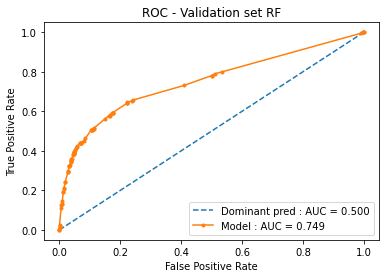

In [265]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


for _ ,val_indices in folds:
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_train[val_indices]))]
    X = X_train[val_indices]
    y = y_train[val_indices]
    lr_probs = cv.best_estimator_.predict_proba(X)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(y, lr_probs)
    # summarize scores
    print('Prediction only dominant class: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dominant pred : AUC = %.3f' % (ns_auc))
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model : AUC = %.3f' % (lr_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend(loc = 'lower right')
    pyplot.title("ROC - Validation set RF")
    # show the plot
    pyplot.show()
    break

Selected variables

In [266]:
k = cv.best_estimator_.named_steps['feature_selection']['SelectKBest'].k
a = cv.best_estimator_.named_steps["feature_selection"]["SelectKBest"].scores_
ind = np.argpartition(a, -k)[-k:][::-1]
a[ind]
df.columns[ind]


Index(['DELAYED', 'PAY_0', 'PAY_2'], dtype='object')

#### Finding optimal cutoff
By maximizing precision-recall. Economics of the problem is not considered. This threshold will give the lowest false positive rate and the highest true positive rate.

In [267]:
 from sklearn.metrics import roc_curve
 preds =cv.best_estimator_.predict_proba(X_train)[:,1]

 fpr, tpr, thresholds = roc_curve(y_train, preds)
 optimal_idx = np.argmax(tpr - fpr)
 optimal_threshold = thresholds[optimal_idx]

 optimal_threshold

0.49293561708177686

#### Testing model

In [268]:
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

model = cv.best_estimator_
pred = (model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(bool) # set threshold as optimal threshold

f1 = metrics.f1_score(y_test, pred)
auc = metrics.roc_auc_score(y_test, pred)
acc = metrics.accuracy_score(y_test, pred)

print('Test f1: {}'.format(f1))
print('Test accuracy: {}'.format(acc))
print('Test auc: {}'.format(auc))

Test f1: 0.5132208511709897
Test accuracy: 0.8047474747474748
Test auc: 0.6848194997664485


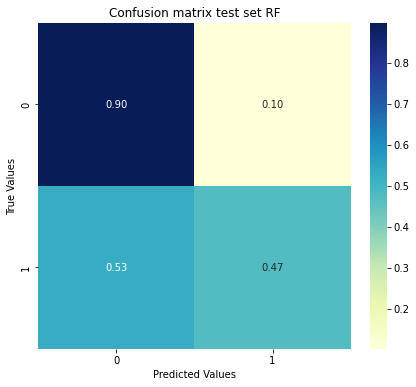

In [269]:
cm = confusion_matrix(y_test, pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.title("Confusion matrix test set RF")
plt.show(block=False)

Prediction only dominant class: ROC AUC=0.500
Model: ROC AUC=0.685


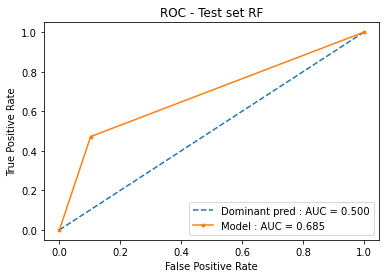

In [270]:
lr_probs = pred
#lr_probs = cv.best_estimator_.predict(X_test)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Prediction only dominant class: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dominant pred : AUC = %.3f' % (ns_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model : AUC = %.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc = 'lower right')
pyplot.title("ROC - Test set RF")
# show the plot
pyplot.show()